# Doctors in Ile-de-France

In [1]:
from pynsee import *

import difflib
import geopandas as gpd
import numpy
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes
import re
from shapely.geometry import Polygon, MultiPolygon

In [2]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [3]:
get_dimension_list().to_csv("sirene_dimensions.csv")

Locally saved data has been used
Set update=True to trigger an update
Locally saved legal data has been used
Set update=True to trigger an update

!!! This function may return personal data, please check and
 comply with the legal framework relating to personal data protection !!!


In [4]:
# get activity list
naf5 = get_activity_list('NAF5')
naf5.to_csv("naf.csv")
naf5[naf5["NAF5"].str.contains("^86.2")]

,A10,A129,A17,A21,A38,A5,A64,A88,NAF1,NAF2,NAF3,NAF4,NAF5,TITLE_NAF5_40CH_FR,TITLE_NAF5_65CH_FR,TITLE_NAF5_FR
664,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.21,86.21Z,Activité des médecins généralistes,Activité des médecins généralistes,Activité des médecins généralistes
665,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.22,86.22A,Act. radiodiagnostic et de radiothérapie,Activités de radiodiagnostic et de radiothérapie,Activités de radiodiagnostic et de radiothérapie
666,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.22,86.22B,Activités chirurgicales,Activités chirurgicales,Activités chirurgicales
667,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.22,86.22C,Autre activité des médecins spécialistes,Autres activités des médecins spécialistes,Autres activités des médecins spécialistes
668,OQ,Q86Z,OQ,Q,QA,OQ,QA0,86,Q,86,86.2,86.23,86.23Z,Pratique dentaire,Pratique dentaire,Pratique dentaire


In [5]:
list_dep = ["91", "92", "93", "75", "77", "78", "95"]

# bretagne
list_dep = ["29", "22", "56", "35"]

# PACA
list_dep = ["05", "06", "04", "83", "84", "13"]
list_dep = ["92", "93", "75", "94"]
list_dep = ["91", "92", "93", "75", "77", "78", "95", "94"]

string_dep = "|".join([dep + "*" for dep in list_dep])
string_dep

'91*|92*|93*|75*|77*|78*|95*|94*'

In [6]:
# search data on doctors

doctors = search_sirene(variable = ["activitePrincipaleEtablissement", "codePostalEtablissement"],
                        pattern = ['86.21Z*', string_dep],
                        number = 100000)
 # '86.21Z' médecin généraliste

doctors = doctors[doctors["activitePrincipaleEtablissement"].str.contains("^86.21Z")].reset_index(drop=True)

!!! Existing environment variables used, instead of locally saved credentials !!!


40/100 - Getting data: 100%|██████████| 387/387 [00:01<00:00, 203.20it/s]


41/100 - No more data found
42/100 - No more data found
Data saved: /home/jovyan/.cache/pynsee/pynsee/e5b224414766f6cb9f53d1aa6f21b707


Getting legal entities:  40%|███▉      | 19/48 [00:02<00:04,  6.64it/s]


API query number limit reached - function might be slowed down


Getting legal entities: 100%|██████████| 48/48 [01:04<00:00,  1.34s/it]


Data saved: /home/jovyan/.cache/pynsee/pynsee/ab02fdc5ba790123196b5f5b0c6ae061


In [7]:
doctors.to_csv('doc.csv')

In [8]:
# doctors[["categorieJuridiqueUniteLegale", "categorieJuridiqueUniteLegaleLibelle"]].drop_duplicates()

In [9]:
# filter
list_pattern = ["RADIOLOGIE", "IMAGERIE", "GYNECO", "DENTAIRE", "ANESTHES", 'P.M.I', 'INFANTILE', 'CARDIOLOG',
                "MAXILLO", "HOSPITALIER", "OPHTALMO", "DERMATOLOG", 'PLANIFICATION', 'MAIRIE', 'THORACIQUE',
                "TOMODENSITOM", "URGENCE", "NEPHROLOG", "PRAXEA", 'VACCINATION', 'SCOLAIRE', 'CANCER', 'STOMATOLO',
                "URODYNAMIQ", "CARDIORIS", "CHIRPLASTIQUE", "NINAMAX", "CICOF", 'MATERNELLE', 'DIALYSE',
                'RADIOTHERAPIE', 'RHUMATOLOG', 'DENTISTE', 'ECHOGRAPH', 'PATHOLOG', 'CHIRURGIE', 'ESTHETIQ',
                'CYTOLOG', 'ORTHOPED']

pattern = r"|".join(list_pattern)


In [10]:
doctors = doctors[~doctors["denominationUniteLegale"].str.contains(pattern, regex=True, na=False)].reset_index(drop=True)
doctors = doctors[~doctors["enseigne1Etablissement"].str.contains(pattern, regex=True, na=False)].reset_index(drop=True)

# exclude association and administration
doctors = doctors[~doctors["categorieJuridiqueUniteLegale"].isin(["9220", "7220"])].reset_index(drop=True)
doctors = doctors.sort_values(["categorieJuridiqueUniteLegale"])

doctors.to_csv("doctors.csv")
list_denomination_uniteLegale = doctors.denominationUniteLegale.unique()
# list_denomination_uniteLegale                 


In [11]:
# get geographical data list
geodata_list = get_geodata_list()

# get communes geographical limits
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

# get arrondissement (subdivision of departement) geographical limits
arr = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:arrondissement')


Previously saved data used
/home/jovyan/.cache/pynsee/pynsee/2ac583be54e866b2b1b30fb0113c1fd0
Set update=True to get the most up-to-date data
Previously saved data used
/home/jovyan/.cache/pynsee/pynsee/a4f589755961ab3aa6bdff99605334d1
Set update=True to get the most up-to-date data
Previously saved data used
/home/jovyan/.cache/pynsee/pynsee/1b27559c061e4bdaa0bd2966f4605287
Set update=True to get the most up-to-date data


In [36]:
# get arrondissement municipal geographical limits
arrmun = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_municipal')
arrmun = arrmun[arrmun.insee_com.str.contains('^75')].reset_index(drop=True)
arrmun["nom_m"] = arrmun["nom_m"].apply(lambda x: re.sub(r"ER|E", "", re.sub(" ARRONDISSEMENT", "", x)))
arrmun = arrmun.rename(columns={"geometry" : "geometry2",
                                "population" : "population2",
                               "nom_m" : "nom_m2"})
arrmun = arrmun[["nom_m2", "geometry2", "population2"]]

In [13]:
def _replace_nan(x, y):
    if (x is None) or (numpy.isnan(x)):
        return y
    else:
        return x

In [14]:
doctors

,siren,nic,siret,dateDebut,dateCreationEtablissement,dateCreationUniteLegale,dateFin,denominationUniteLegale,nomUniteLegale,prenomUsuelUniteLegale,...,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,complementAdresse2Etablissement,indiceRepetition2Etablissement,libelleCommuneEtranger2Etablissement,distributionSpeciale2Etablissement,codeCedex2Etablissement,libelleCedex2Etablissement,codePaysEtranger2Etablissement,libellePaysEtranger2Etablissement
15010,950575050,00022,95057505000022,2008-01-01,2000-10-01,1989-07-10,None,None,SANDANA,ANTHONY,...,None,None,None,None,None,None,None,None,None,None
8478,448901140,00021,44890114000021,2015-11-06,2015-11-06,2000-07-31,None,None,GNOUOGUIA TAGNE,DELPHINE,...,None,None,None,None,None,None,None,None,None,None
13893,853948156,00015,85394815600015,2019-08-01,2019-08-01,2019-08-01,None,None,DE DIEULEVEULT,YORICK,...,None,None,None,None,None,None,None,None,None,None
8480,448901462,00060,44890146200060,2019-02-01,2019-02-01,2003-04-20,None,None,ZAKINE,GILBERT,...,None,None,None,None,None,None,None,None,None,None
8481,448901728,00023,44890172800023,2008-01-01,2005-04-01,2002-10-02,None,None,ADELMASSY,WALID,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,313711038,00015,31371103800015,2008-01-01,1978-01-01,1978-01-01,None,FONDATION HAHNEMANN,None,None,...,None,None,None,None,None,None,None,None,None,None
10966,775663883,00020,77566388300020,2008-01-01,1900-01-01,1900-01-01,None,INSTITUT ARTHUR VERNES,None,None,...,None,None,None,None,None,None,None,None,None,None
10981,775683006,00362,77568300600362,2017-06-21,2017-06-21,1900-01-01,None,FONDATION SANTE DES ETUDIANTS DE FRANCE,None,None,...,None,None,None,None,None,None,None,None,None,None
316,310227749,00010,31022774900010,2008-01-01,1900-01-01,1900-01-01,None,CENTRE DE SOINS,None,None,...,None,None,None,None,None,None,None,None,None,None


In [15]:
# count general practioners by commun
hdLegalStatus = doctors.groupby(['categorieJuridiqueUniteLegale'], dropna=True)['effectifsMinEtablissement'].agg(['mean', "count"])
   
hdLegalStatus["meanHeadcountLegalStatus"] = hdLegalStatus["mean"].apply(lambda x: _replace_nan(x, 1))

hdLegalStatus["categorieJuridiqueUniteLegale"] = hdLegalStatus.index
hdLegalStatus.loc[hdLegalStatus["categorieJuridiqueUniteLegale"] == "1000", "meanHeadcountLegalStatus"] = 1
hdLegalStatus = hdLegalStatus.reset_index(drop=True)

doctors = doctors.merge(hdLegalStatus, how = "left", on = "categorieJuridiqueUniteLegale").reset_index(drop=True)

for r in doctors.index:
    hdMin = doctors.loc[r, "effectifsMinEtablissement"]
    if (hdMin is None) or (numpy.isnan(hdMin)):
        doctors.loc[r, "headcount"] = doctors.loc[r, "meanHeadcountLegalStatus"]
    else:
        doctors.loc[r, "headcount"] = hdMin


In [16]:
# duplicates cleaning
# normalization to avoid double counting
doctors["headcountFinal"] = doctors["headcount"] / doctors.groupby("siren", dropna=True)["headcount"].transform("sum")

#visual check duplicates
dupDoctors = doctors[doctors["siren"].duplicated(keep=False)].reset_index(drop=True)
dupDoctors.to_csv("dupDoctors.csv")

list_adress_var = ["numeroVoieEtablissement", "typeVoieEtablissementLibelle", 
                   "libelleVoieEtablissement", "codePostalEtablissement", "libelleCommuneEtablissement"]

addressDupDoctors = doctors[doctors[list_adress_var].duplicated(keep=False)].reset_index(drop=True)
addressDupDoctors = addressDupDoctors.sort_values(list_adress_var)
addressDupDoctors.to_csv("addressDupDoctors.csv")

In [17]:
doctors.sort_values(["libelleCommuneEtablissement"]).to_csv("doctorSortedCom.csv")

In [18]:
# count general practioners by commun

doctorsCom = doctors.groupby(['libelleCommuneEtablissement', 'codePostalEtablissement'])['headcountFinal'].agg(['sum'])
doctorsCom = doctorsCom.rename(columns = {"sum" : "headcount"})
doctorsCom

,,headcount
libelleCommuneEtablissement,codePostalEtablissement,
ABLIS,78660,3.000000
ABLON-SUR-SEINE,94480,2.500000
ACHERES,78260,12.000000
ACHERES-LA-FORET,77760,0.500000
ALFORTVILLE,94140,30.250000
...,...,...
VOISINS-LE-BRETONNEUX,78960,11.000000
VOULX,77940,4.000000
VULAINES-SUR-SEINE,77870,4.000000


In [19]:
doctorsCom["libelleCommuneEtablissement"] = doctorsCom.index.get_level_values("libelleCommuneEtablissement")
doctorsCom["codePostalEtablissement"] = doctorsCom.index.get_level_values("codePostalEtablissement")
doctorsCom = doctorsCom.reset_index(drop=True)

In [20]:
import os, sys 

communes = get_geo_list("communes")

def _find_commune_identifier(com, dep, communes=communes):
    
    try:
        list_com = [c.upper() for c in communes.TITLE.to_list()]    
        communes["TITLE"] = list_com    
        communes = communes[communes["CODE_DEP"] == dep].reset_index(drop=True)

        match = difflib.get_close_matches(com.upper(), list_com)[0]

        cog = communes[communes["TITLE"] == match].reset_index(drop=True)
        cog = cog.loc[0, "CODE"]
    except:
        cog = None
    
    return cog      
  
for r in doctorsCom.index:
    dep = doctorsCom.loc[r, "codePostalEtablissement"][:2]
    comName = doctorsCom.loc[r, "libelleCommuneEtablissement"]
    doctorsCom.loc[r, "insee_com"] = _find_commune_identifier(comName, dep)


Locally saved data has been used
Set update=True to trigger an update


In [24]:
comDep = com[com["insee_dep" ].isin(list_dep)].reset_index(drop=True)
doctorsCom2 = comDep.merge(doctorsCom, how = "left", on = "insee_com")
doctorsCom2.to_csv("doctorsDep.csv")

In [26]:
doctorsCom2["headcount"] = doctorsCom2["headcount"].apply(lambda x: _replace_nan(x, 0))

doctorsCom3 = doctorsCom2.copy().groupby(["insee_arr"])[["population", "headcount"]].agg(["sum"])
doctorsCom3["ratio"] = 1000 * doctorsCom3["headcount"] / doctorsCom3["population"]
doctorsCom3["insee_arr"] = doctorsCom3.index
doctorsCom3 = doctorsCom3.reset_index(drop=True)

arrDep = arr[arr["insee_dep"].isin(list_dep)].reset_index(drop=True)
doctorsCom3 = doctorsCom3.merge(arrDep[["insee_arr", "geometry"]], how= "left", on = "insee_arr")
doctorsCom3 = doctorsCom3.rename(columns = {"('ratio','')" : "ratio"})
doctorsCom3.columns = ["insee_arr", "population", "headcount", "ratio", "insee_arr2", "geometry"]
doctorsCom3

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  return merge(


,insee_arr,population,headcount,ratio,insee_arr2,geometry
0,1,47799570,6720.891103,0.140606,1,"(POLYGON ((263182.01671144 6243765.25756816, 2..."
1,1,47799570,6720.891103,0.140606,1,"(POLYGON ((322265.87345218 6287946.6228104, 32..."
2,1,47799570,6720.891103,0.140606,1,"(POLYGON ((169012.50312614 6271197.65027422, 1..."
3,1,47799570,6720.891103,0.140606,1,"(POLYGON ((219042.28287385 6194856.7107581, 21..."
4,1,47799570,6720.891103,0.140606,1,"(POLYGON ((253606.20819294 6243401.87012695, 2..."
5,1,47799570,6720.891103,0.140606,1,"(POLYGON ((268294.30642005 6260725.57658092, 2..."
6,1,47799570,6720.891103,0.140606,1,"(POLYGON ((274756.07552845 6234636.82506559, 2..."
7,1,47799570,6720.891103,0.140606,1,"(POLYGON ((248365.3624873 6283673.2844393, 248..."
8,2,3853233,3503.814155,0.909318,2,"(POLYGON ((281783.49491065 6202823.58483382, 2..."
9,2,3853233,3503.814155,0.909318,2,"(POLYGON ((189584.45269257 6240926.67520392, 1..."


In [27]:
doctorsCom2["headcount"] = doctorsCom2["headcount"].apply(lambda x: _replace_nan(x, 0))
doctorsCom2["ratio"] = 1000 * doctorsCom2["headcount"] / doctorsCom2["population"]
doctorsCom2.loc[doctorsCom2["nom_m"] == "CHEVANNES", "ratio"] = 2
doctorsCom2.sort_values(["ratio"], ascending=False)

,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,bbox,crs,headcount,libelleCommuneEtablissement,codePostalEtablissement,ratio
785,COMMUNE_0000000009740130,Roinvilliers,ROINVILLIERS,91526,Commune simple,107,08,1,91,11,200017846,"(POLYGON ((250049.53501001 6161865.64613179, 2...","[245706.74420296, 6161543.54066951, 251246.133...",EPSG:3857,1.000000,ROINVILLIERS,91150,9.345794
945,COMMUNE_0000000009736500,Jossigny,JOSSIGNY,77237,Commune simple,656,22,5,77,11,247700594,"(POLYGON ((306391.53836197 6249591.98342643, 3...","[305343.01824851, 6242023.11272052, 310058.075...",EPSG:3857,6.000000,JOSSIGNY,77600,9.146341
1077,COMMUNE_0000000009734513,Villiers-le-Sec,VILLIERS-LE-SEC,95682,Commune simple,189,09,2,95,11,200073013,"(POLYGON ((266744.03698707 6289583.07241044, 2...","[263521.76530462, 6285635.06747645, 267739.656...",EPSG:3857,1.000000,VILLIERS-LE-SEC,95720,5.291005
579,COMMUNE_0000000009739715,Valence-en-Brie,VALENCE-EN-BRIE,77480,Commune simple,1048,14,2,77,11,200070779,"(POLYGON ((325845.24966123 6179547.29484033, 3...","[318270.89013511, 6177932.36299577, 325845.249...",EPSG:3857,5.000000,VALENCE-EN-BRIE,77830,4.770992
770,COMMUNE_0000000009736058,Le Port-Marly,LE PORT-MARLY,78502,Commune simple,5481,03,3,78,11,200058519,"(POLYGON ((234901.89559035 6255796.25391045, 2...","[233882.96105394, 6253145.91756075, 235973.049...",EPSG:3857,24.166667,LE PORT-MARLY,78560,4.409171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,COMMUNE_0000000009738359,Voisenon,VOISENON,77528,Commune simple,1154,11,2,77,11,247700057,"(POLYGON ((297707.15744816 6203784.48062281, 2...","[295052.09535556, 6200307.43325515, 297987.563...",EPSG:3857,0.000000,NaN,NaN,0.000000
506,COMMUNE_0000000009740525,Larchant,LARCHANT,77244,Commune simple,681,15,4,77,11,200023240,"(POLYGON ((286750.50242365 6149466.52820769, 2...","[283841.39899263, 6149051.76400811, 295010.629...",EPSG:3857,0.000000,NaN,NaN,0.000000
507,COMMUNE_0000000009736496,Coutevroult,COUTEVROULT,77141,Commune simple,1167,21,1,77,11,200090504,"(POLYGON ((315667.15104848 6251299.25651938, 3...","[314319.31052423, 6246042.3010237, 319046.6838...",EPSG:3857,0.000000,NaN,NaN,0.000000
509,COMMUNE_0000000009734988,Penchard,PENCHARD,77358,Commune simple,1315,03,1,77,11,200072130,"(POLYGON ((320331.62153294 6273393.21096804, 3...","[315878.80991065, 6270846.15065135, 320331.621...",EPSG:3857,0.000000,NaN,NaN,0.000000


In [28]:
doctorsCom2 = doctorsCom2.reset_index(drop=True)

doctorsCom4 = doctorsCom2[doctorsCom2.columns].merge(arrmun, left_on ="libelleCommuneEtablissement", right_on="nom_m2", how="left")
for i in doctorsCom4.index:
    if type(doctorsCom4.loc[i, 'geometry2']) in [MultiPolygon, Polygon]:
        doctorsCom4.loc[i, 'geometry'] = doctorsCom4.loc[i, 'geometry2']
        doctorsCom4.loc[i, "ratio"] = 1000 * doctorsCom4.loc[i,"headcount"] / doctorsCom4.loc[i,"population2"]
#octorsCom4[doctorsCom4.nom.str.contains("Paris")]
del doctorsCom4["geometry2"]
doctorsCom2Map = gpd.GeoDataFrame(doctorsCom4)

In [34]:
doctorsCom2Map = gpd.GeoDataFrame(doctorsCom4)

#fig, ax = plt.subplots(1,1,figsize=[10,10])
#doctorsCom2Map.plot(column='ratio', cmap=cm.viridis,
#    legend=True, ax=ax)
#ax.set_axis_off()
#ax.set(title='Distribution of general practioners (medecins generalistes) in France')
#plt.show()


In [33]:
#doctorsCom3Map = gpd.GeoDataFrame(doctorsCom3)

#fig, ax = plt.subplots(1,1,figsize=[10,10])
#doctorsCom3Map.plot(column='ratio', cmap=cm.viridis,
#    legend=True, ax=ax)
#ax.set_axis_off()
#ax.set(title='Distribution of general practioners (medecins generalistes) in France')
#plt.show()

In [31]:

doctorsCom2Map.loc[doctorsCom2Map.ratio < 1, 'range'] = "< 0.2"
doctorsCom2Map.loc[doctorsCom2Map.ratio >= 5, 'range'] = "> 5"

density_ranges = [0.2, 0.6, 1, 1.5, 2, 2.5, 3, 3.5, 5]
list_ranges = []
list_ranges.append( "< 0.2")

for i in range(len(density_ranges)-1):
    min_range = density_ranges[i]
    max_range = density_ranges[i+1]
    range_string = "[{}, {}[".format(min_range, max_range)
    rows = (doctorsCom2Map.ratio >= min_range) & (doctorsCom2Map.ratio < max_range)
    doctorsCom2Map.loc[rows, 'range'] = range_string
    list_ranges.append(range_string)

list_ranges.append("> 5")

doctorsCom2Map['range2'] = doctorsCom2Map['range'].astype(CategoricalDtype(categories=list_ranges, ordered=True))

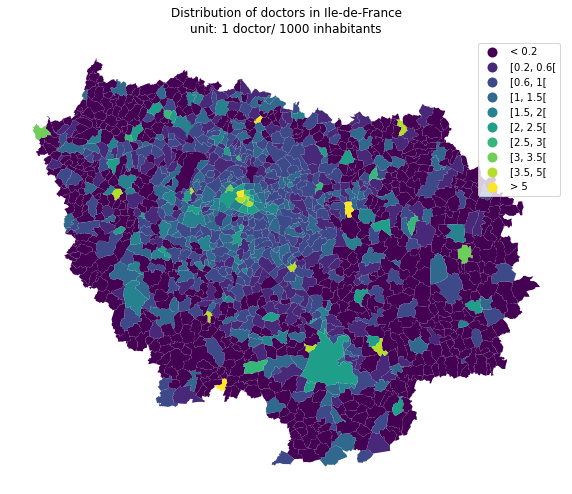

In [39]:
fig, ax = plt.subplots(1,1,figsize=[10,10])
doctorsCom2Map.plot(column='range2', cmap=cm.viridis,
    legend=True, ax=ax)
ax.set_axis_off()
ax.set(title='Distribution of doctors in Ile-de-France\nunit: 1 doctor/ 1000 inhabitants')
plt.show()